In [106]:
from tesserocr import PyTessBaseAPI, RIL

import PIL.Image as PImage

In [107]:
import numpy as np
from IPython.display import display, Image
from io import BytesIO

import math

In [108]:
def display_img(im):
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png', retina=True))

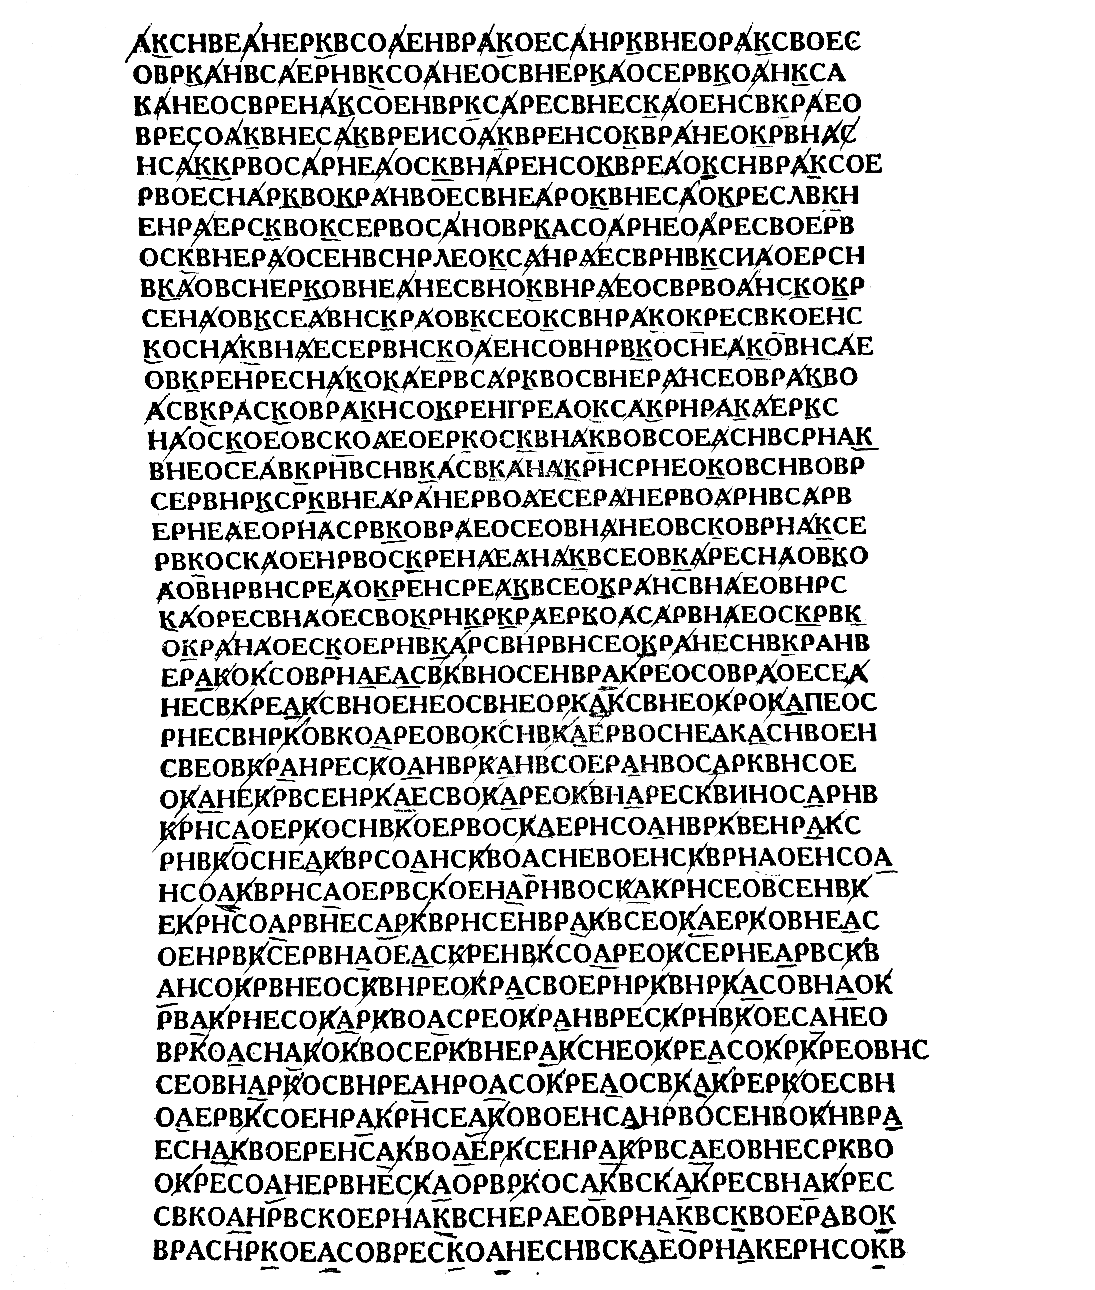

In [109]:
display_img(PImage.open('./res/table_real.jpg').convert('L'))

In [111]:
image = PImage.open('./res/table_real.jpg').convert('L')

api = PyTessBaseAPI(lang='rus')
api.SetImage(image)

height_bias = 1.5

letters = api.GetComponentImages(RIL.SYMBOL, True)
letters = [(b[0]) for b in letters]
mean_w, mean_h = letter_means(letters, height_bias)

print('Mean width: {}, mean height: {}'.format(mean_w, mean_h))

letters = filter_out_small_width(letters, mean_w)
letters = filter_out_small_height(letters, mean_h, height_bias=height_bias)

print('Found {} symbols'.format(len(letters)))

Mean width: 18.185434929197573, mean height: 30.266014834794337
Found 1472 symbols


In [63]:
def letter_means(letters, height_bias):
    widths = []
    heights = []

    for i, lt in enumerate(letters):
        widths.append(lt.width)
        heights.append(lt.height)
        
    return np.mean(widths), np.mean(heights) * height_bias

In [64]:
def shift_round(float_val, limit):
    lo = math.floor(float_val)
    hi = lo + 1
    diff = float_val - lo
    
    return lo if diff < limit else hi

In [17]:
def split_letters_by_means(img, mean_w, mean_h):
    cols = shift_round(img.width / mean_w, 0.8)
    rows = shift_round(img.height / mean_h, 0.5)
    
    print(img.width / mean_w, img.height / mean_h)

    # because it's better to avoid division by zero
    if rows == 0 or cols == 0:
        return
    
    rows_pics = []
    letter_pics = []
    
    row_h = img.height / rows
    col_w = img.width / cols
    
    for r_id in range(0, rows):
        top = row_h * r_id
        bot = min(img.height, row_h * (r_id + 1))
        
        result_row = img.crop((0, top, img.width, bot))
#         display_img(result_row)
        
        rows_pics.append(result_row)
        
    for i, r_pic in enumerate(rows_pics):
        for c_id in range(0, cols):
            left = col_w * c_id
            right = min(img.width, col_w * (c_id + 1))
            
            result_letter = r_pic.crop((left, 0, right, r_pic.height))
            display_img(result_letter)
            
            letter_pics.append(result_letter)

In [65]:
def split_horizontal_by_mean(img, mean_h):
    rows = shift_round(img.height / mean_h, 0.5)
    
    print(img.height / mean_h)

    # because it's better to avoid division by zero
    if rows == 0:
        return
    
    row_h = img.height / rows
    rows_pics = []
    
    for r_id in range(0, rows):
        top = row_h * r_id
        bot = min(img.height, row_h * (r_id + 1))
        
        result_row = img.crop((0, top, img.width, bot))
        display_img(result_row)
        
        rows_pics.append(result_row)
        
    return rows_pics

In [66]:
def filter_out_small_width(letters, mean_w, min_scale=0.7):
    result = []
    
    for lt in letters:
        if lt.width / mean_w > min_scale:
            result.append(lt)
            
    return result

In [68]:
def filter_out_small_height(letters, mean_h, height_bias=1.5, min_scale=0.3):
    result = []
    
    for lt in letters:
        if (lt.height * height_bias) / mean_h > min_scale:
            result.append(lt)
            
    return result

In [70]:
def trim_whiteness_by_x(row_image):
    row_arr = np.array(row_image)
    
    white_col = 250
    prev = 0
    
    letters = []
    trim_range = []
    
    for i in range(0, row_image.width):
        avg = np.average(row_arr[:, i])

        if avg > white_col and len(trim_range) == 0:
            continue

        if avg < white_col and len(trim_range) == 0:
            trim_range.append(i)
            continue

        if avg > white_col and len(trim_range) == 1:
            trim_range.append(i)
            break
    
    left, right = trim_range[0], trim_range[1]
    
    return row_image.crop(left, 0, right, row_image.height)

In [112]:
line = []
all_lines = []

for i, lt in enumerate(letters):
    line.append(lt)
    
    if (i + 1) % 40 == 0 or i == len(letters) - 1:
        all_lines.append(line)
        line = []

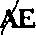

In [113]:
for l in all_lines[0]:
#     print(len(l))
    display_img(l)